In [1]:
import os
import sys
from time import time
import numpy as np
import h5py 
import seaborn as sns
import scipy.interpolate as interpolate
import gmpy2 as gmp

from importlib import reload

sys.path.append('/Users/theoares/lqcd/utilities')
import plottools as pt
from formattools import *
# import formattools as ft
pt.set_font()
# style = styles['notebook']
default_style = styles['notebook']

# import jax
# from jax.config import config
# config.update("jax_enable_x64", True)
# import jax.numpy as np
import numpy as np

sys.path.append('/Users/theoares/lqcd_analysis/lqcd_analysis')
# from lqcd_analysis import visualize as plt
import visualize as plt
# import matplotlib.pyplt as plt

sys.path.append('/Users/theoares/lqcd/spectral/recon_tools')
# from inverse_problems import jax_spline
import jax_spline

sys.path.append('/Users/theoares/inverse_problems/inverse_problems')
from inverse_problems import nevanlinna as nv

# I/O functions

In [2]:
def mpc_conj(c):
    conj_c = np.zeros(c.shape, dtype = object)
    for ii, x in enumerate(c):
        conj_c[ii] = gmp.mpc.conjugate(x)
    return conj_c
def mpc_abs(c):
    """Input c should be a list of gmp.mpc objects."""
    abs_c = np.zeros(c.shape, dtype = object)
    for ii, x in enumerate(c):
        abs_c[ii] = gmp.sqrt(gmp.mpc.conjugate(x) * x).real
    return abs_c

In [3]:
def phase(z):
    return np.exp(1j*np.arctan2(z.imag, z.real))

def generate():
    #os.system("pushd /Users/theoares/lqcd/spectral/python_scripts; python3 generate.py data.h5; mv data.h5 /Users/theoares/inverse_problems/nevanlinna_disk/; popd; pwd;")
    os.system("pwd; python3 generate.py /Users/theoares/lqcd/spectral/simulations/data.h5;")

def run(eta="0.0001"):
    os.system(f"/Users/theoares/inverse_problems/nevanlinna_disk/Nevanlinna /Users/theoares/lqcd/spectral/simulations/data.h5 /Users/theoares/lqcd/spectral/simulations/recon.h5 {eta}")
    
def read_ng(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        # print(ifile['freqs_imag'][:])
        freq_re = np.array(ifile['freqs_real'][:], dtype=float)
        freq_im = np.array(ifile['freqs_imag'][:], dtype=float)
        ng_re = np.array(ifile['ng_real'][:], dtype=float)
        ng_im = np.array(ifile['ng_imag'][:], dtype=float)
        freq = freq_re + 1j*freq_im
        ng = ng_re + 1j*ng_im
    return freq, ng

def read_phis(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        phis_re = np.array(ifile['phi_real'][:], dtype=float)
        phis_im = np.array(ifile['phi_imag'][:], dtype=float)
        phis = phis_re + 1j*phis_im
    return phis

def read_eigs(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        eigs_re = np.array(ifile['eigs_real'][:], dtype=float)
        eigs_im = np.array(ifile['eigs_imag'][:], dtype=float)
        #eigs = eigs_re + 1j*eigs_im
        eigs = eigs_re
    return eigs

def read(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        # Reconstructed frequencies
        start = np.array(ifile['start'][:], dtype=float).item()
        stop = np.array(ifile['stop'][:], dtype=float).item()
        num = np.array(ifile['num'][:], dtype=int).item()
        omega = np.linspace(start, stop, num=num)
        # 
        real = np.array(ifile['recon_real'][:], dtype=float)
        imag = np.array(ifile['recon_imag'][:], dtype=float)
        rho = real + 1j*imag
    return omega, rho

def read_nev_coeffs(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        print(ifile.keys())
        
        # Reconstructed frequencies
        start = np.array(ifile['start'][:], dtype=float).item()
        stop = np.array(ifile['stop'][:], dtype=float).item()
        num = np.array(ifile['num'][:], dtype=int).item()
        omega = np.linspace(start, stop, num=num)
        tmp = {}
        for key in ['P','Q','R','S']:
            tmp[f'{key}_re'] = np.array(ifile[f'{key}_real'][:], dtype=float)
            tmp[f'{key}_im'] = np.array(ifile[f'{key}_imag'][:], dtype=float)
        
        # DON'T NORMALIZE: destroys the identities we want to keep intact
        # norm = np.max(np.array(list(tmp.values())))
        # for key in tmp:
        #     tmp[key] = tmp[key]/norm
        nev_coeffs = {}
        
        # Rephase a,b,c,d
        for key in ['P','Q','R','S']:
            nev_coeffs[key] = tmp[f'{key}_re'] + 1j*tmp[f'{key}_im']        
        phi = phase(nev_coeffs['P'][0])
        for key in nev_coeffs:
            nev_coeffs[key] = nev_coeffs[key]/phi
    return omega, nev_coeffs

def build_bspline(x, y):
    t, c, k = interpolate.splrep(x, y, s=0, k=4)
    bspline = interpolate.BSpline(t, c, k, extrapolate=False)
    return bspline    

def kernel(x, x0, sigma):
    dx = x - x0
    return np.exp(-0.5*dx**2/sigma**2) / (np.sqrt(2*np.pi) * sigma)

In [4]:
def analytic_ft(z, m, beta):
    prefactor = -1*(1 + np.exp(-m*beta))
    pole1 = 1/(z - m)
    pole2 = 1/(z + m)
    return prefactor * (pole1 + pole2)

# Generate data, run reconstruction

In [5]:
# Generate data
generate()

# Compute spectral function
# eta_str = '1.0'
# eta_str = '0.5'
# eta_str = '0.2'
# eta_str = '0.15'
eta_str = '0.1'        # default
# eta_str = '0.05'
# eta_str = '0.01'
# eta_str = '0.0001'
# eta_str = '1e-8'
# eta_str = '1e-12'
# eta_str = '1e-16'
eta = float(eta_str)
run(eta = eta_str)

# Read spectral
omega, rho = read("recon.h5")

/Users/theoares/lqcd/spectral/python_scripts
Writing data to: /Users/theoares/lqcd/spectral/simulations/data.h5
Normalization of spectral density 1.9999994266956174
C(t=0) 1.0000020658310698 (direct)
C(t=0) 1.0 (spline)
[0.+0.30927486j 0.+0.32761088j 0.+0.32000933j 0.+0.30173199j
 0.+0.28028224j 0.+0.25899188j 0.+0.23918751j 0.+0.22128204j
 0.+0.20529146j 0.+0.1910731j  0.+0.17843338j 0.+0.16717485j
 0.+0.15711521j 0.+0.14809354j 0.+0.13997095j 0.+0.13262885j
 0.+0.12596653j 0.+0.11989863j 0.+0.11435288j 0.+0.10926808j
 0.+0.1045922j  0.+0.10028072j 0.+0.09629507j 0.+0.0926013j
 0.+0.08916926j 0.+0.08597223j 0.+0.08298665j 0.+0.08019188j
 0.+0.07756996j 0.+0.07510517j 0.+0.07278374j 0.+0.0705935j
 0.+0.06852365j 0.+0.06656453j 0.+0.06470752j 0.+0.06294482j
 0.+0.06126941j 0.+0.05967494j 0.+0.05815565j 0.+0.0567063j
 0.+0.05532211j 0.+0.05399872j 0.+0.05273214j 0.+0.0515187j
 0.+0.05035496j 0.+0.04923773j]
Green's function data written to: /Users/theoares/lqcd/spectral/simulations/data.

## Plot results

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':"Nevanlinna Green's function"}, xlabel='$2\\pi\\omega_n$', ylabel='$C(i\\omega_n)$'>)

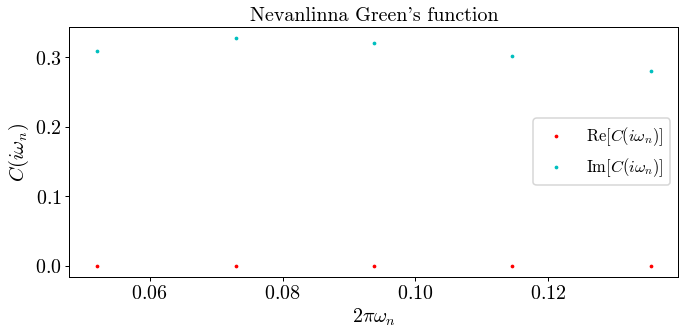

In [6]:
reload(pt)

# NG Green function - on imaginary axis
freq, ng = read_ng("recon.h5")
phis = read_phis("recon.h5")

# Solve the interpolation problem on the disk of w_i = f(z_i)
z_list = nv.moebius(freq)
w_list = nv.moebius(ng)

x = freq.imag / (2*np.pi)
pt.scatter_1d(x, ng, ax_label = [r'$2\pi\omega_n$', r'$C(i\omega_n)$'], mkr = 'o', fn_label = r'C(i\omega_n)', \
              title = 'Nevanlinna Green\'s function', legend = True)

In [7]:
# real part should be identically zero
ng

array([0.+0.30927486j, 0.+0.32761088j, 0.+0.32000933j, 0.+0.30173199j,
       0.+0.28028224j])

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:xlabel='$\\omega$', ylabel='$\\rho$'>)

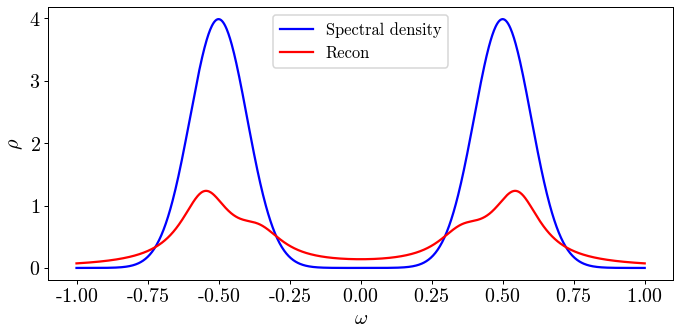

In [8]:
freq, ng = read_ng("recon.h5")
omega, rho = read("recon.h5")

# Expected spectral density (Gaussian)
sigma = 0.1
# sigma = 0.15
# x = np.linspace(-1, 1, num=1000)
# rho_gt = rho_gt_full[np.logical_and(x >= -1, x <= 1)]

# Expected spectral density (Gaussian)
rho_gt = np.exp(-0.5*(omega - 0.5)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)
rho_gt += np.exp(-0.5*(omega + 0.5)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)

# Expected spectral density (delta function)
# rho_gt = np.zeros((1000))
# rho_gt[np.logical_and(omega > 0.049, omega < 0.051)] = np.max(rho.imag * 2/3)
# rho_gt[np.logical_and(omega > 0.099, omega < 0.101)] = np.max(rho.imag * 2/3)

fig, ax = pt.plot_1d_data(omega, rho_gt, col = 'b', fn_label = 'Spectral density')

# Reconstructed spectral density
f = build_bspline(omega, rho.imag)
pt.plot_1d_data(omega, rho.imag, ax = ax, ax_label = [r'$\omega$', r'$\rho$'], fn_label = 'Recon', legend = True)

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Smearing kernel'}, xlabel='$\\omega$', ylabel='$\\delta_\\epsilon$'>)

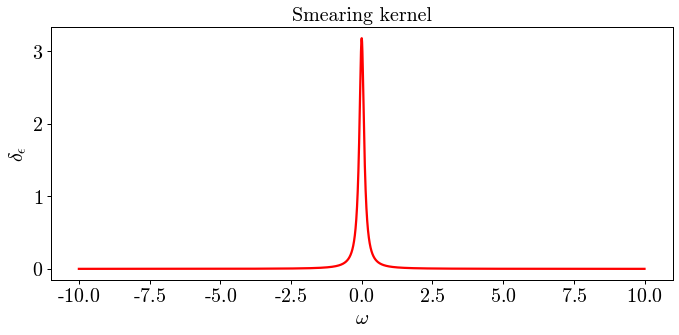

In [9]:
# Smear spectral function rho_gt
omega_conv = np.linspace(-10, 10, num=10000)
rho_gt_full = np.exp(-0.5*(omega_conv - 0.5)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)
rho_gt_full += np.exp(-0.5*(omega_conv + 0.5)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)

def delta_eps(z, epsilon = eta):
    return (epsilon / np.pi) / (z**2 + epsilon**2)
delta_eps_grid = np.array([delta_eps(w) for w in omega_conv], dtype = np.float64)
pt.plot_1d_data(omega_conv, delta_eps_grid, ax_label = [r'$\omega$', r'$\delta_\epsilon$'], title = 'Smearing kernel')

(-1.0, 1.0)

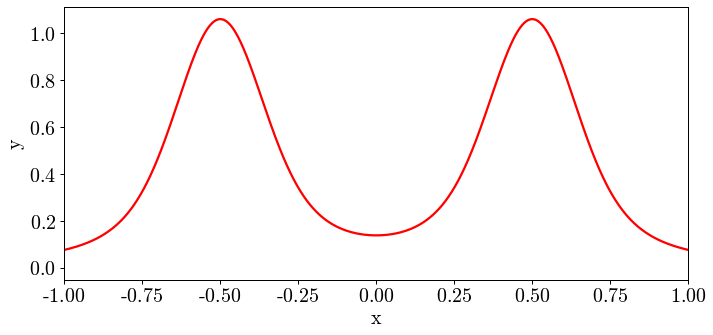

In [10]:
Delta_omega = (1/2) * (np.max(omega_conv) - np.min(omega_conv)) / len(omega_conv)            # Convert sum to integral
# Delta_omega = (np.max(omega_conv) - np.min(omega_conv)) / len(omega_conv)            # Convert sum to integral
rho_smeared_full = np.convolve(delta_eps_grid, rho_gt_full, 'same') * Delta_omega
fig, ax = pt.plot_1d_data(omega_conv, rho_smeared_full)
ax.set_xlim((-1, 1))
# rho_smeared = rho_smeared_full[np.logical_and(x >= -1.0, x <= 1.0)]

### Get eigenvalues of Pick matrix

In [11]:
# Note that all the offending eigenvalues have magnitude < machine epsilon (10^{-16})
eigs = read_eigs('recon.h5')
ϵ = 1e-15
# eigs[np.abs(eigs) < ϵ] = 0
eigs

array([1.71732036e-09, 3.17091327e-06, 2.94742360e-04, 1.09039849e-01,
       3.93186629e+00])

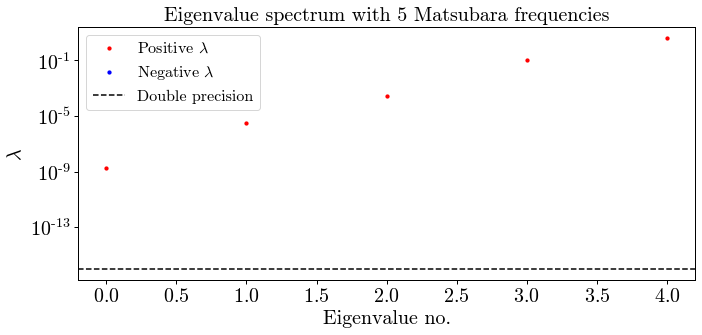

In [12]:
mystyle = default_style.copy()
mystyle['markersize'] = 30
n_eigs = len(eigs)
eig_ids = range(n_eigs)
fig, ax = pt.scatter_1d(eig_ids, eigs, logy = True, fn_label = r'Positive $\lambda$', col = 'r', style = mystyle)
pt.scatter_1d(eig_ids, -eigs, ax = ax, logy = True, fn_label = r'Negative $\lambda$', col = 'b', style = mystyle, \
              ax_label = [r'Eigenvalue no.', r'$\lambda$'], \
              title = r'Eigenvalue spectrum with ' + str(n_eigs) + ' Matsubara frequencies',)
pt.add_line(ax, 1e-16, c = 'k', label = 'Double precision', orientation = 'h', linestyle = 'dashed')
ax.legend(fontsize = 16)
fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/tests/eig_spec_' + str(n_eigs) + 'freqs.pdf', \
            bbox_inches = 'tight')

In [13]:
# fig, ax = pt.scatter_1d(range(40), eigs, ax_label = [r'Eigenvalue no.', r'$\lambda$'], ylims = (-0.02, 0.02))
# pt.add_line(ax, 0, orientation = 'h', label = '0')

In [14]:
# np.max(rho_smeared_full)

In [15]:
# # If the convolution was correct, we would expect the maximum to be at x = 0.5 (one of the Gaussian centers)
# x[np.argmax(rho_smeared_full)]
# x[np.argmax(rho_smeared_full) + 9]

In [16]:
# TODO: make sure that the convolution is computed correctly!
# Probably seeing extra boundary stuff, since we're only computing the convolution from -1 to 1
# We should really just compute it analytically and then plug it in, because right now it seems to be suffering from numerical artifacts


# Study Nevanlinna coefficients analytically

<KeysViewHDF5 ['P_imag', 'P_real', 'Q_imag', 'Q_real', 'R_imag', 'R_real', 'S_imag', 'S_real', 'beta', 'eigs_imag', 'eigs_real', 'eta', 'freqs_imag', 'freqs_real', 'ng_imag', 'ng_real', 'num', 'phi_imag', 'phi_real', 'recon_imag', 'recon_real', 'start', 'stop', 'w_list_imag', 'w_list_real', 'zeta_list_imag', 'zeta_list_real']>


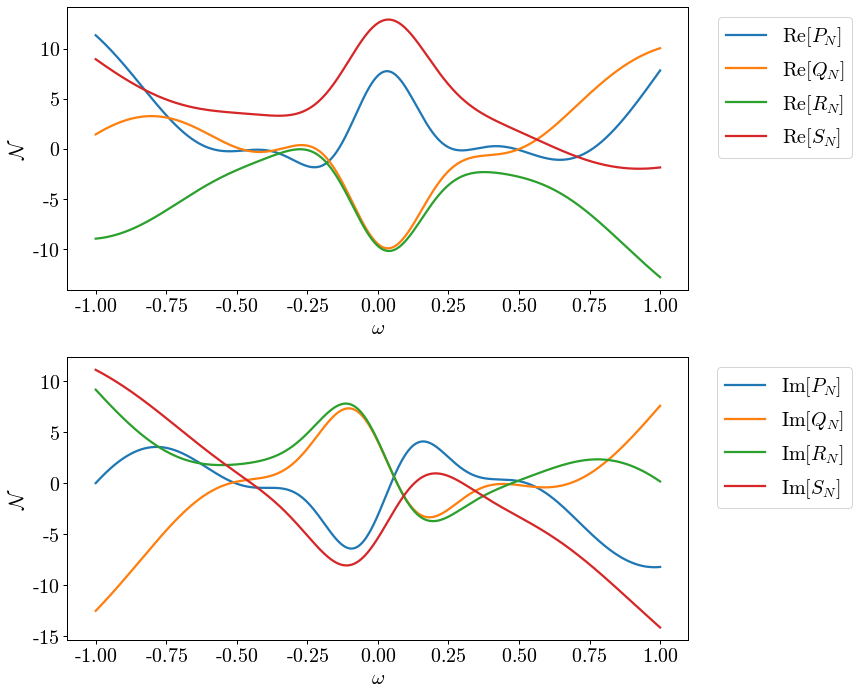

In [17]:
omega, nev_coeffs = read_nev_coeffs("recon.h5")
nev_cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, axes = pt.add_subplots(n_rows = 2)
[ax1, ax2] = axes
for ii, key in enumerate(['P','Q','R','S']):
    pt.plot_1d_data(omega, nev_coeffs[key].real, ax = ax1, col = nev_cols[ii], ax_label = [r'$\omega$', \
                      r'$\mathcal{N}$'], fn_label = r'$\mathrm{Re}['+key+'_N]$')
    pt.plot_1d_data(omega, nev_coeffs[key].imag, ax = ax2, col = nev_cols[ii], ax_label = [r'$\omega$', \
                      r'$\mathcal{N}$'], fn_label = r'$\mathrm{Im}['+key+'_N]$')

ax1.legend(bbox_to_anchor=(1.28, 1), loc='upper right', fontsize = default_style['fontsize'])
ax2.legend(bbox_to_anchor=(1.28, 1), loc='upper right', fontsize = default_style['fontsize'])

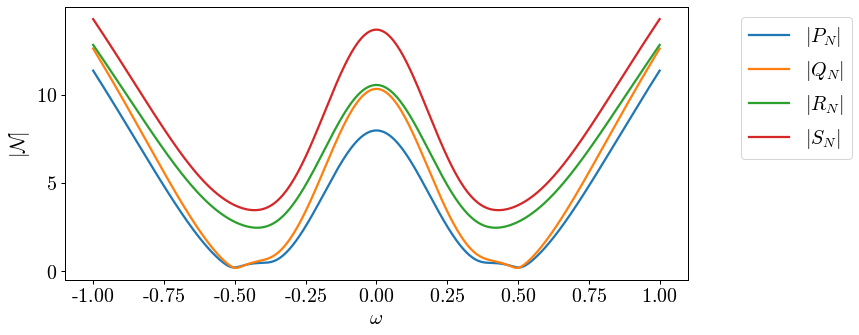

In [18]:
fig, axes = pt.add_subplots()
ax = axes[0]
for ii, key in enumerate(['P','Q','R','S']):
    pt.plot_1d_data(omega, np.abs(nev_coeffs[f"{key}"]), ax = ax, col = nev_cols[ii], \
                      ax_label = [r'$\omega$', r'$|\mathcal{N}|$'], fn_label = r'$|'+key+'_N|$')
ax.legend(bbox_to_anchor=(1.28, 1), loc='upper right', fontsize = default_style['fontsize'])

In [19]:
# Confirm the relation P_N S_N - Q_N R_N = B_N
def B_N(z):
    b = 1.0
    #for iw in freq:
    for hfreq in z_list:
        b *= nv.blashke(z, hfreq)
    return b
# B_N should have zeros at the corresponding frequencies
print([B_N(hfreq) for hfreq in z_list])

[(-0+0j), 0j, -0j, (-0+0j), 0j]


In [20]:
print(freq)      # NOTE THESE ARE STILL MATSUBARA FREQS, DON'T USE THEM
print(z_list)    # MOBIUS TRANSFORM OF MATSUBARA FREQS, USE THESE

[0.+0.32724923j 0.+0.45814893j 0.+0.58904862j 0.+0.71994832j
 0.+0.85084801j]
[-0.50687599-0.j -0.37160201-0.j -0.25861473-0.j -0.16282564-0.j
 -0.08058576-0.j]


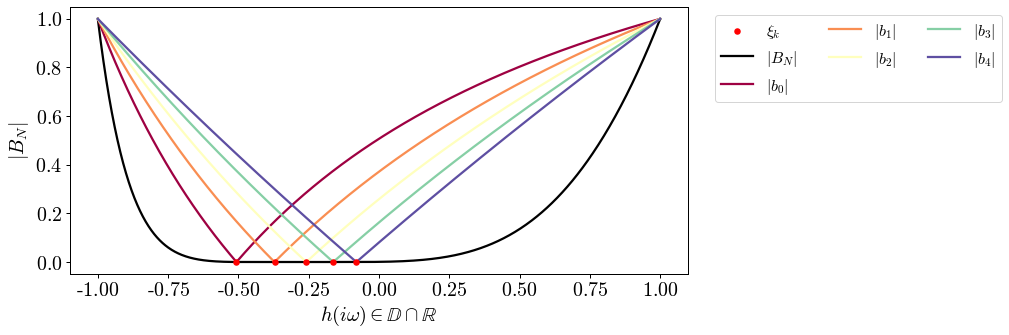

In [21]:
# Plot the Blashke product B_N on the real axis (should have zeros at the given frequencies)
re_axis = np.linspace(-1.0, 1.0, num = 1000)

import matplotlib as mpl
blaschke_cols = mpl.cm.get_cmap('Spectral')(np.linspace(0, 1, len(freq)))

fig, axes = pt.add_subplots()
ax1 = axes[0]

freq_style = default_style.copy()
freq_style['markersize'] = 100
pt.scatter_1d(np.real(z_list), np.zeros(len(freq)), ax = ax1, col = 'r', fn_label = r'$\xi_k$', zorder = 10, style = freq_style)
pt.plot_1d_data(re_axis, np.abs(np.array([B_N(x) for x in re_axis])), ax = ax1, fn_label = r'$|B_N|$', col = 'k')
for ii in range(len(freq)):
    pt.plot_1d_data(re_axis, np.abs(np.array([nv.blashke(x, z_list[ii]) for x in re_axis])), ax = ax1, \
                       fn_label = r'$|b_{' + str(ii) + r'}|$', ax_label=[r'$h(i\omega)\in\mathbb{D}\cap\mathbb{R}$', \
                       r'$|B_N|$'], col = blaschke_cols[ii])

ax1.legend(bbox_to_anchor=(1.52, 1), loc='upper right', ncol=3, fontsize = '16')
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/blashke_real_axis.pdf', bbox_inches = 'tight')

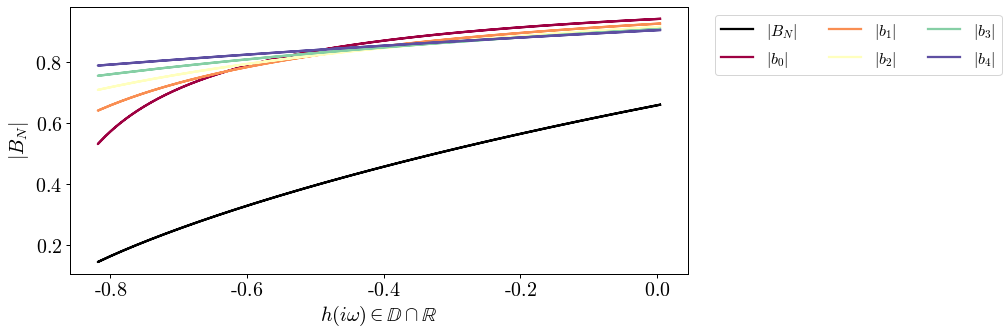

In [22]:
# Plot the Blashke product B_N on the evaluation axis
# ev_axis = nv.moebius(np.linspace(0.0, 0.2, num = 1000) + 1j*1e-10)
# ev_axis = nv.moebius(np.linspace(0.0, 0.2, num = 1000) + 1j*eta)
ev_axis = nv.moebius(np.linspace(-1.0, 1.0, num = 1000) + 1j*eta)

fig, axes = pt.add_subplots()
ax1 = axes[0]

pt.plot_1d_data(np.real(ev_axis), np.abs(np.array([B_N(x) for x in ev_axis])), ax = ax1, fn_label = r'$|B_N|$', col = 'k')
for ii in range(len(freq)):
    pt.plot_1d_data(np.real(ev_axis), np.abs(np.array([nv.blashke(x, z_list[ii]) for x in ev_axis])), ax = ax1, \
                      fn_label = r'$|b_{' + str(ii) + r'}|$', ax_label=[r'$h(i\omega)\in\mathbb{D}\cap\mathbb{R}$', \
                      r'$|B_N|$'], col = blaschke_cols[ii])

ax1.legend(bbox_to_anchor=(1.52, 1), loc='upper right', ncol=3, fontsize = '16')
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/blashke_eval_axis.pdf', bbox_inches = 'tight')

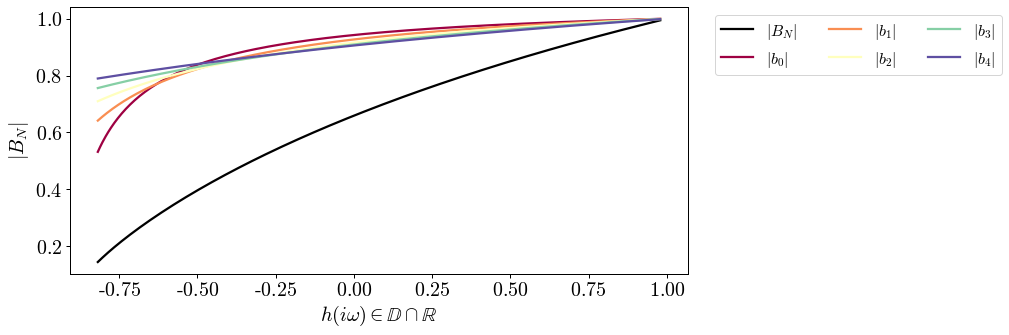

In [23]:
# Plot the Blashke product B_N on the evaluation axis
ev_axis = nv.moebius(np.linspace(0.0, 10.0, num = 1000) + 1j*eta)

fig, axes = pt.add_subplots()
ax1 = axes[0]

pt.plot_1d_data(np.real(ev_axis), np.abs(np.array([B_N(x) for x in ev_axis])), ax = ax1, fn_label = r'$|B_N|$', col = 'k')
for ii in range(len(freq)):
    pt.plot_1d_data(np.real(ev_axis), np.abs(np.array([nv.blashke(x, z_list[ii]) for x in ev_axis])), ax = ax1, \
                      fn_label = r'$|b_{' + str(ii) + r'}|$', ax_label=[r'$h(i\omega)\in\mathbb{D}\cap\mathbb{R}$', \
                      r'$|B_N|$'], col = blaschke_cols[ii])

ax1.legend(bbox_to_anchor=(1.52, 1), loc='upper right', ncol=3, fontsize = '16')
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/blashke_eval_axis_full.pdf', bbox_inches = 'tight')

### Evaluate $P_N S_N - Q_N R_N$ with double precision

In [24]:
# eval_line = nv.moebius(x + 1j*eta)
eval_line = nv.moebius(omega + 1j*eta)
B_N_eval = np.array([B_N(z) for z in eval_line])

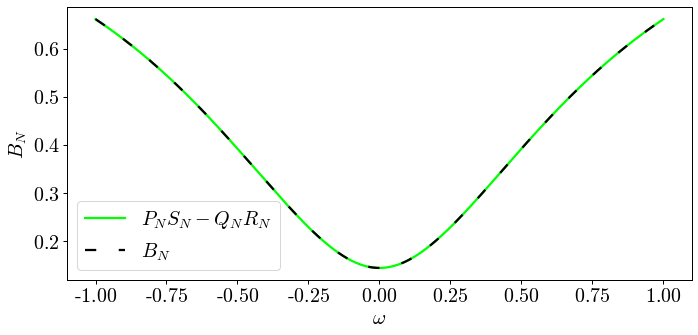

In [25]:
fig, axes = pt.add_subplots()
ax1 = axes[0]
det = nev_coeffs['P'] * nev_coeffs['S'] - nev_coeffs['Q'] * nev_coeffs['R']

pt.plot_1d_data(omega, np.abs(det), ax = ax1, fn_label=r'$P_N S_N - Q_N R_N$', col = 'lime')
pt.plot_1d_data(omega, np.abs(B_N_eval), ax = ax1, fn_label=r'$B_N$', col = 'k', linestyle = (0, (5, 10)))
pt.add_xlabel(ax1, r'$\omega$')
pt.add_ylabel(ax1, r'$B_N$')
ax1.legend(fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/det_identity_double_prec.pdf', bbox_inches = 'tight')

### Evaluate $P_N S_N - R_N Q_N$ at extended precision

TODO: check out how the curves vary as we vary the number of input points

Once you go to a sufficiently large number of Matsubara frequencies, you need extended precision on the Nevanlinna coefficients to reproduce the desired identities. I'm not yet sure how this scales, but it might be a good idea to play with. 

The key here is that even if the input data is double precision and has error bars (i.e. it's imprecise), you **still need to keep extended precision on the Nevanlinna coefficients to reproduce the desired identities**. Even if your input data is not extended precision, the Nevanlinna problem is **still a well-defined mathematical problem**, and satisfies all the identities proved in the paper. However, to see these identities in action, you **must treat the problem with extended precision**. 

In [26]:
# prec = 128
prec = 1028
gmp.get_context().allow_complex = True
gmp.get_context().precision = prec

ONE = gmp.mpc(1, 0)
I = gmp.mpc(0, 1)
h = lambda z : (z - I) / (z + I)
hinv = lambda q : I * (gmp.mpc(1, 0) + q) / (gmp.mpc(1, 0) - q)
eta_mpc = gmp.mpc(eta_str)

def read_nev_coeffs_extended(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        # Reconstructed frequencies
        start = np.array(ifile['start'][:], dtype=float).item()
        stop = np.array(ifile['stop'][:], dtype=float).item()
        num = np.array(ifile['num'][:], dtype=int).item()
        omega = np.linspace(start, stop, num=num)
        tmp = {}
        for key in ['P','Q','R','S']:
            tmp[f'{key}_re'] = np.array([gmp.mpc(x) for x in ifile[f'{key}_real'][()]], dtype=object)
            tmp[f'{key}_im'] = np.array([gmp.mpc(x) for x in ifile[f'{key}_imag'][()]], dtype=object)
        
        # DON'T NORMALIZE: destroys the identities we want to keep intact
        nev_coeffs = {}
        
        # Rephase a,b,c,d
        for key in ['P','Q','R','S']:
            nev_coeffs[key] = tmp[f'{key}_re'] + gmp.mpc(0, 1) * tmp[f'{key}_im']        
        # phi = phase(nev_coeffs['P'][0])
        # for key in nev_coeffs:
        #     nev_coeffs[key] = nev_coeffs[key]/phi
    return omega, nev_coeffs

omega_ext, nev_coeffs_ext = read_nev_coeffs_extended("recon.h5")

In [27]:
# Confirm the relation P_N S_N - Q_N R_N = B_N
def B_N_ext(z):
    b = ONE
    for hfreq in z_list:
        b *= nv.blashke(z, hfreq)
    return b
eval_line_ext = np.array([nv.moebius(gmp.mpc(xx) + I*eta) for xx in omega], dtype = 'object')
B_N_eval_ext = np.array([B_N_ext(z) for z in eval_line_ext])

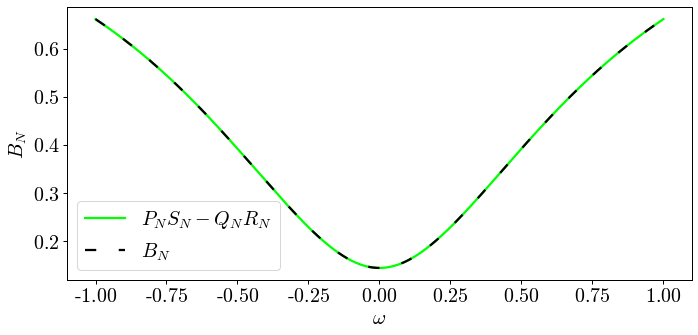

In [28]:
fig, axes = pt.add_subplots()
ax1 = axes[0]
det = np.complex128(nev_coeffs_ext['P'] * nev_coeffs_ext['S'] - nev_coeffs_ext['Q'] * nev_coeffs_ext['R'])

pt.plot_1d_data(omega, np.abs(det), ax = ax1, fn_label=r'$P_N S_N - Q_N R_N$', col = 'lime')
pt.plot_1d_data(omega, np.abs(np.complex128(B_N_eval)), ax = ax1, fn_label=r'$B_N$', col = 'k', linestyle = (0, (5, 10)))
pt.add_xlabel(ax1, r'$\omega$')
pt.add_ylabel(ax1, r'$B_N$')
ax1.legend(fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/det_identity_ext_prec.pdf', bbox_inches = 'tight')

### Verify that $P_N(z) = B_N(z) S_N(1/z^*)^*$ and $Q_N(z) = B_N(z) R_N(1/z^*)^*$

This might be hard to do with the data we have, since $z = h(\omega + i\eta)$ and likely do not have the Nevanlinna coefficients evaluated at $1/z^*$. However, we may want to use these identities to define the phase of the Nevanlinna coefficients. 

### Evaluate $|S_N|^2 - |R_N|^2$

Might be interesting to compute $|S|^2 - |R|^2$ at different $\eta$ values and plot them against one another. Analytically, we know that on the boundary of the disk $\partial\mathbb D$, this value should be 1:
$$
    |S_N|^2 - |R_N|^2 = 1.
$$

Note two things:
- This identity need only hold on the boundary of the disk, hence we may need to take $\eta\ll 1$ to see anything resembling this identity. Indeed for the two-pole reconstruction, I can't resolve anything going on with even the correct order of magnitude until we get down to about $\eta\sim 10^{-12}$, and even at that very small value of $\eta$ we still get weird fluctuations. Going smaller, we see the identity almost holding at $\eta = 10^{-16}$, but there's a lot of noise at large $\omega$. 
- It seems that numerically, $|S_N|^2 - |R_N|^2 = -1$ instead of $+1$ on the boundary of the disk. Should definitely figure out what's going on here, since this enters the vertevorrat construction. 

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:xlabel='$\\omega$', ylabel='$|S|^2 - |R|^2$'>)

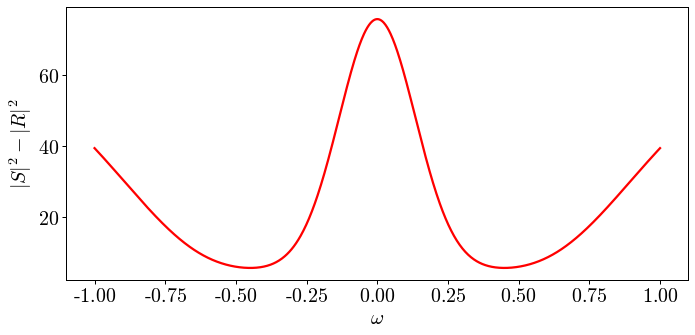

In [29]:
pt.plot_1d_data(omega, np.abs(nev_coeffs['S'])**2 - np.abs(nev_coeffs['R'])**2, fn_label=r'$|S|^2 - |R|^2$', \
                  ax_label = [r'$\omega$', r'$|S|^2 - |R|^2$'])

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Extended precision'}, xlabel='$\\omega$', ylabel='$|S|^2 - |R|^2$'>)

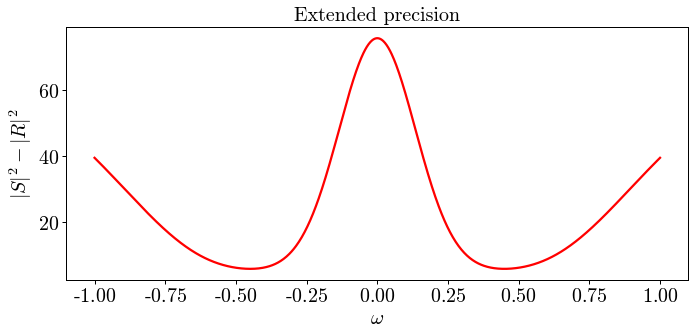

In [30]:
y = np.float64(mpc_abs(nev_coeffs_ext['S'])**2 - mpc_abs(nev_coeffs_ext['R'])**2)
pt.plot_1d_data(omega, y, fn_label=r'$|S|^2 - |R|^2$', ax_label = [r'$\omega$', r'$|S|^2 - |R|^2$'],\
                  title = 'Extended precision')

### Make sure I can reconstruct the spectral function with $\theta_{N+1} \equiv 0$

In [31]:
rho_zero_fn_disk = nev_coeffs_ext['Q'] / nev_coeffs_ext['S']
rho_zero_fn = hinv(rho_zero_fn_disk)

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Recon with $\\theta_{N+1} = 0$'}, xlabel='$\\omega$', ylabel='$\\rho$'>)

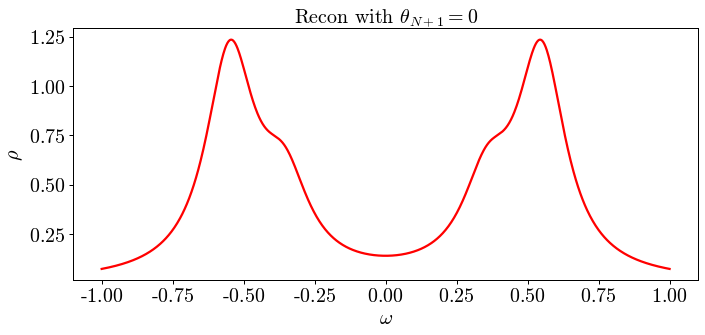

In [32]:
pt.plot_1d_data(omega, np.complex128(rho_zero_fn).imag, ax_label = [r'$\omega$', r'$\rho$'], \
                title = r'Recon with $\theta_{N+1} = 0$')

### Evaluate the center and radius of the solution disk

Analytically, the set of all possible solutions at $\zeta\in\mathbb D$ is 
$$
    \Delta(\zeta) := \{ f(\zeta) : f \text{ is a Nevanlinna interpolant}  \},
$$
and can be proven to be a Euclidean disk of center 
$$
    c_N(\zeta) := \frac{P_N(\zeta) \left( -\frac{R_N}{S_N}(\zeta) \right)^* + Q_N(\zeta)}{R_N(\zeta) \left( -\frac{R_N}{S_N}(\zeta) \right)^* + S_N(\zeta)} = \frac
    {Q_N(\zeta) \bar{S}_N(\zeta) - P_N(\zeta) \bar{R}_N(\zeta)}
    {|S_N(\zeta)|^2 - |R_N(\zeta)|^2}
$$
with radius:
$$
    \rho_N(\zeta) := \frac{|B_N(\zeta)|}{|S_N(\zeta)|^2 - |R_N(\zeta)|^2}.
$$
Note that solutions are in the disk, and need to be mapped back to the complex plane with $h^{-1}$. 

In [33]:
rN = mpc_abs(B_N_eval_ext) / (mpc_abs(nev_coeffs_ext['S'])**2 - mpc_abs(nev_coeffs_ext['R'])**2)
mRoverS_conj = mpc_conj( -nev_coeffs_ext['R'] / nev_coeffs_ext['S'] )
cN = (nev_coeffs_ext['P']*mRoverS_conj+nev_coeffs_ext['Q']) / (nev_coeffs_ext['R']*mRoverS_conj+nev_coeffs_ext['S'])

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Pullback of $c_N$'}, xlabel='$\\omega$', ylabel='$\\mathrm{Im}[h^{-1}\\circ c_N]$'>)

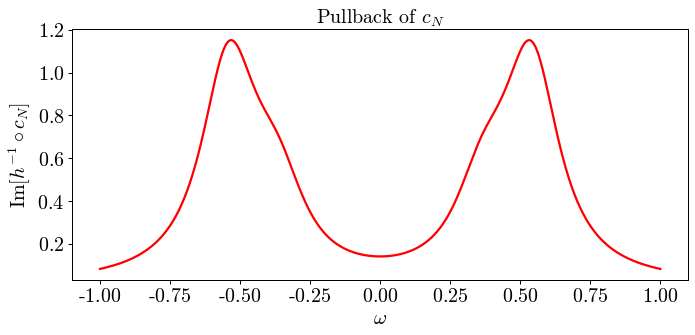

In [34]:
rho_center = hinv(cN)
pt.plot_1d_data(omega, np.complex128(rho_center).imag, title = r'Pullback of $c_N$', \
                  ax_label = [r'$\omega$', r'$\mathrm{Im}[h^{-1}\circ c_N]$'])

#### Plot the wertevorrat (both in $\mathbb D$ and in $\mathbb C^+$)

In [35]:
# now with error bands
ex_idx = 100
# tt_float = np.linspace(0, 1, num = 1000)
# tt = np.zeros(tt_float.shape, dtype = object)
# for idx, t in enumerate(tt_float):
#     tt[idx] = gmp.mpc(t)
# tt = np.linspace(0, 1, num = 100)
tt = np.linspace(0, 1, num = 1000)
dDelta = np.zeros((len(cN), len(tt)), dtype = object)
dGamma = np.zeros((len(cN), len(tt)), dtype = object)
for ii in range(len(cN)):
    #dDelta[ii] = cN[ii] + rN[ii] * np.exp(2*np.pi*1j*tt)
    for tidx, t in enumerate(tt):
        dDelta[ii, tidx] = cN[ii] + rN[ii] * gmp.exp(gmp.mpc('2')*gmp.const_pi()*gmp.mpc(0, 1)*gmp.mpc(str(t)))
    #dDelta[ii] = cN[ii] + rN[ii] * gmp.exp(gmp.mpc('2')*gmp.const_pi()*gmp.mpc(0, 1)*tt)
    dGamma[ii] = hinv(dDelta[ii])
dDelta_float = np.complex128(dDelta)
dGamma_float = np.complex128(dGamma)
cN_float = np.complex128(cN)
rN_float = np.float64(rN)

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:xlabel='$\\mathrm{Re}[\\Gamma]$', ylabel='$\\mathrm{Im}[\\Gamma]$'>)

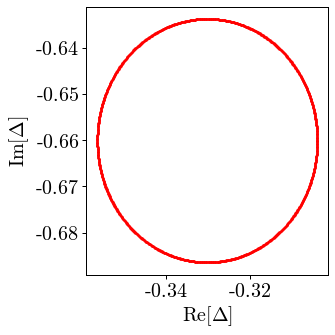

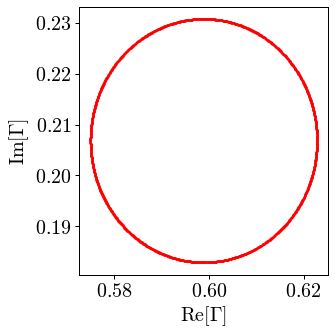

In [36]:
pt.scatter_1d(dDelta_float[ex_idx].real, dDelta_float[ex_idx].imag, fig_size = [5, 5], \
              ax_label = [r'$\mathrm{Re}[\Delta]$', r'$\mathrm{Im}[\Delta]$'])
pt.scatter_1d(dGamma_float[ex_idx].real, dGamma_float[ex_idx].imag, fig_size = [5, 5], \
              ax_label = [r'$\mathrm{Re}[\Gamma]$', r'$\mathrm{Im}[\Gamma]$'])

In [37]:
# TODO add a 1 / np.pi here
pi_Gamma = dGamma_float.imag
delta_rho_plus = np.max(pi_Gamma, axis = 1)
delta_rho_minus = np.min(pi_Gamma, axis = 1)

In [38]:
np.max(delta_rho_minus)

1.0159665533650064

Currently the smeared spectral function is lying just outside the wertevorrat: what's going on here?
When the wertevorrat is smaller, it's obviously easier for the smeared $\rho$ to lie outside of it (i.e. you only see this as $\eta$ gets larger and larger) but (**think about and verify this**) the wertevorrat should always contain the ground truth smeared spectral function, no matter how small it is

In [39]:
# %matplotlib notebook

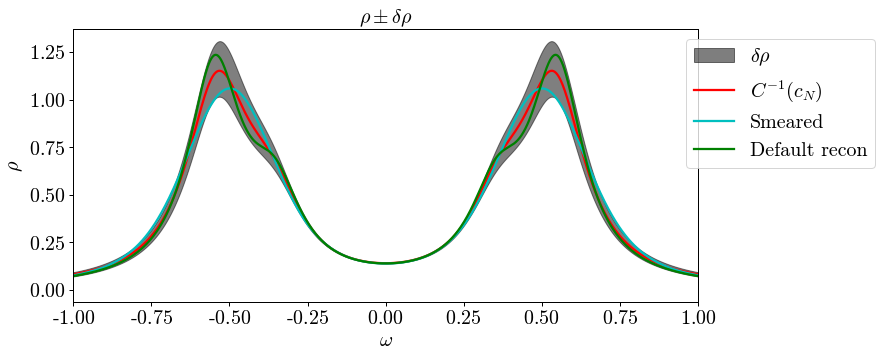

In [40]:

fig, axes = pt.add_subplots()
ax = axes[0]
ax.fill_between(omega, delta_rho_minus, delta_rho_plus, color = 'k', alpha = 0.5, label = r'$\delta\rho$')
pt.plot_1d_data(omega, np.complex128(rho_center).imag, ax = ax, col = 'r', fn_label = r'$C^{-1}(c_N)$')

# pt.plot_1d_data(omega, rho_smeared, ax = ax, col = 'c', fn_label = 'Smeared')
pt.plot_1d_data(omega_conv, rho_smeared_full, ax = ax, col = 'c', fn_label = 'Smeared')

# pt.plot_1d_data(omega, np.complex128(rho_center).imag, ax = ax, col = 'r', fn_label = r'$C^{-1}(c_N)$')
pt.plot_1d_data(omega, np.complex128(rho_zero_fn).imag, ax = ax, fn_label = r'Default recon', col = 'g')

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$\rho$')
ax.set_title(r'$\rho\pm\delta\rho$', fontsize = default_style['fontsize'])

ax.set_xlim((-1.0, 1.0))
# ax.set_xlim((0.54, 0.55))
# ax.set_ylim((0.8, 0.846))

# ax.set_xlim((0.78, 0.85))
# ax.set_ylim((-0.1, 2.0))

pt.stylize_axis(ax)
ax.legend(bbox_to_anchor=(1.3, 1), loc='upper right', fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/wertevorrat_smeared_rho.pdf', bbox_inches = 'tight')

In [41]:
print('Default reconstruction (theta_{m+1} = 0) lies inside wertevorrat:')
print(np.all(np.logical_and(delta_rho_minus <= np.complex128(rho_zero_fn).imag, np.complex128(rho_zero_fn).imag <= delta_rho_plus)))
# print(np.logical_and(delta_rho_minus <= np.complex128(rho_zero_fn).imag, np.complex128(rho_zero_fn).imag <= delta_rho_plus))

# print('Smeared spectral function lies inside wertevorrat:')
# print(np.all(np.logical_and(delta_rho_minus <= np.complex128(rho_zero_fn).imag, np.complex128(rho_zero_fn).imag <= delta_rho_plus)))

Default reconstruction (theta_{m+1} = 0) lies inside wertevorrat:
True


(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'$(\\delta\\rho^+ - \\delta\\rho^-) / \\rho$'}, xlabel='$\\omega$', ylabel='$|\\delta\\rho| / \\rho$'>)

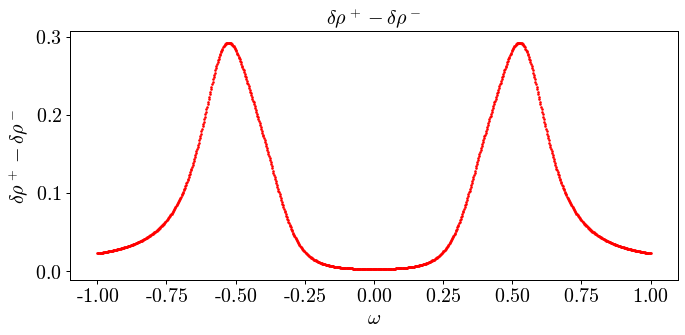

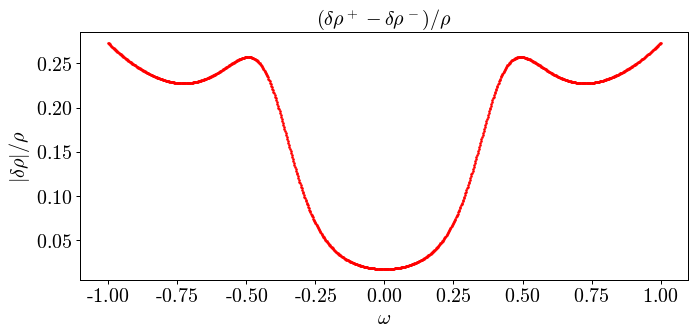

In [42]:
pt.scatter_1d(omega, delta_rho_plus - delta_rho_minus, ax_label = \
              [r'$\omega$', r'$\delta\rho^+ - \delta\rho^-$'], title = r'$\delta\rho^+ - \delta\rho^-$')
pt.scatter_1d(omega, (delta_rho_plus - delta_rho_minus) / np.complex128(rho_center).imag, ax_label = \
              [r'$\omega$', r'$|\delta\rho| / \rho$'], title = r'$(\delta\rho^+ - \delta\rho^-) / \rho$')

### Verify that $|S_N(\zeta)|$ is the largest Nevanlinna coefficient

In [43]:
bad_idxs = np.where(np.abs(cN_float) >= 1)[0]
print('Indices where |c_N|\geq 1: ' + str(bad_idxs))
# These indices correspond to points where $|S_N|^2 - |R_N|^2 has a zero crossing! This combination should always be positive (from the math paper)

Indices where |c_N|\geq 1: []


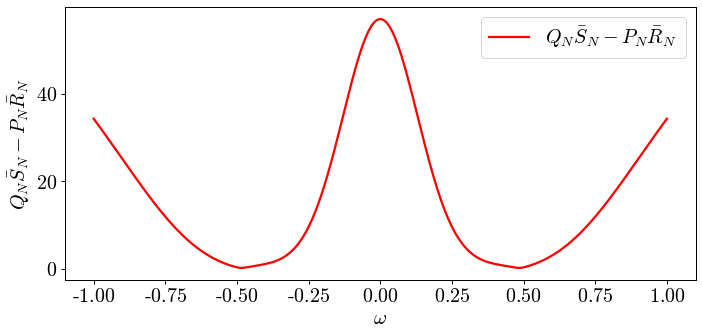

In [44]:
# Look at Q_N(\zeta) \bar{S}_N(\zeta) - P_N(\zeta) \bar{R}_N(\zeta)
fig, axes = pt.add_subplots()
ax1 = axes[0]
num_cN = np.complex128(nev_coeffs_ext['Q'] * mpc_conj(nev_coeffs_ext['S']) - nev_coeffs_ext['P'] * mpc_conj(nev_coeffs_ext['R']))

pt.plot_1d_data(omega, np.abs(num_cN), ax = ax1, fn_label=r'$Q_N \bar{S}_N - P_N \bar{R}_N$', col = 'r')
pt.add_xlabel(ax1, r'$\omega$')
pt.add_ylabel(ax1, r'$Q_N \bar{S}_N - P_N \bar{R}_N$')
ax1.legend(fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/det_identity_ext_prec.pdf', bbox_inches = 'tight')

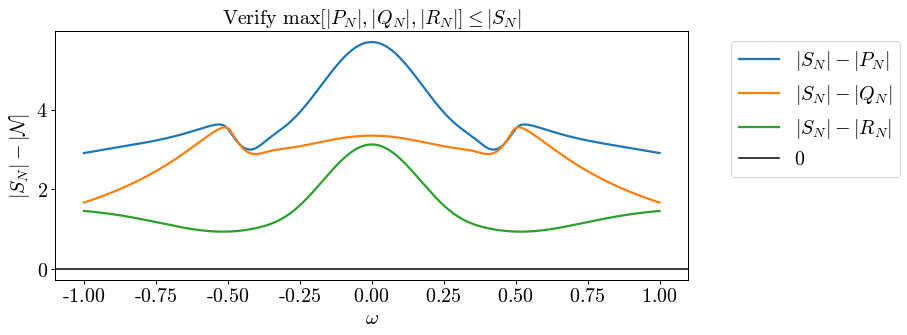

In [45]:
# Verify that |S| \geq |P|, |Q|, |R|
fig, axes = pt.add_subplots()
ax = axes[0]
for ii, key in enumerate(['P','Q','R']):
    pt.plot_1d_data(omega, np.abs(nev_coeffs['S']) - np.abs(nev_coeffs[key]), ax = ax, col = nev_cols[ii],\
                      ax_label = [r'$\omega$', r'$|S_N| - |\mathcal{N}|$'], fn_label = r'$|S_N| - |'+key+'_N|$', \
                      title = r'Verify $\max[|P_N|, |Q_N|, |R_N|] \leq |S_N|$')
pt.add_line(ax, 0, orientation = 'h', c = 'k', label = '0')
lbl = r'$|c_N| > 1$'
for tmp_idx in bad_idxs:
    pt.add_line(ax, omega[tmp_idx], c = 'c', label = lbl)
    lbl = '_nolegend_'
ax.legend(bbox_to_anchor=(1.35, 1), loc='upper right', fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/broken_identity_gaussian.pdf', bbox_inches = 'tight')

Note that the following 3 plots are $\rho_N$, $\mathrm{Im}[c_N]$, and $\mathrm{Re}[c_N]$: these are still subsets of $\mathbb D$, so **don't expect them to look like anything you can interpret**!

In [46]:
# pt.plot_1d_data(omega, np.complex128(rN).real, title = r'Radius of $\Delta$', \
#                   ax_label = [r'$\omega$', r'$r_N$'])

In [47]:
# pt.plot_1d_data(omega, np.complex128(cN).real, title = r'Real part of center of $\Delta$', \
#                   ax_label = [r'$\omega$', r'$\mathrm{Re}[c_N]$'])
# pt.plot_1d_data(omega, np.complex128(cN).imag, title = r'Imaginary part of center of $\Delta$', \
#                   ax_label = [r'$\omega$', r'$\mathrm{Im}[c_N]$'], col = 'b')

**Figures to make**
1. Edit Cayley transform figure: color palette, think about arrows and $\pm \infty$ points, change notation to $C$ instead of $h$. Shift $C$ and $C^{-1}$ to be diagonal maps, can adjust $\mathbb C^+$ and $\mathbb D$ to be on the diagonal
2. Similar figure but for $\tilde{C}$
3. Cayley tranform figure for evaluation axis $\omega + i\eta$ and Matsubara frequencies.
4. Figure for pulling back wertevorrat into $\mathbb C^+$ and projecting it onto the imaginary axis.

**Next steps**
1. Make sure that Euclidean data is exact at extended precision: zero out any real part of NG when we start the problem (or imaginary part)
2. Use Pick matrix to diagnose when the data we're using has $\geq 1$ solution (add Pick matrix code to the cpp project)
3. Can play with Gaussian recon on 40 timeslices (really weird peaks there, namely the center $c_N$ of the wertevorrat lies outside the disk)
3. Smear spectral function and verify that it lies in the wertevorrat.
4. Approximate the Gaussian with a $\delta$ train and derive the analytic result for the Laplace transform (or use a multi-pole reconstruction and find a malicious counterexample)
5. Try to reconstruct $R$-ratio data

In [48]:
def kernel(omega, beta, tau):
    return (np.exp(-omega*tau) + np.exp(-omega*(beta-tau)))/(1 + np.exp(-beta*tau))

In [49]:
# beta = 48
# sigma = 0.1
# corrs = []
# # x_lst = []
# for N in [10, 100, 1000, 10000, 100000]:
#     x = np.linspace(0, 10*sigma, num=N)
#     #x_lst.append(x)
#     # x = np.linspace(0, 1, num=20000)
#     # rho = np.exp(-0.5*x**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)
#     rho = np.exp(-0.5*(x - 0.5)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)
#     rho += np.exp(-0.5*(x + 0.5)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)
#     rho = 2*rho  # Unit normalized on [0, infinity)

#     print("Normalization of spectral density", np.trapz(x=x, y=rho))

#     # Euclidean-time correlator = Laplace transform of the spectral density
#     tau = np.arange(beta)  # Evaluate on the lattice grid [0, ..., beta-1]
#     corr = np.array([np.trapz(x=x, y=rho*kernel(x, beta, tau_i)) for tau_i in tau])
#     corrs.append(corr)
# corrs = np.array(corrs)

In [50]:
# # fig, ax = pt.add_subplots(ncol = 5)
# pt.scatter_1d(range(beta), corrs[0], logy=True)

In [51]:
# tau = 5
# pt.scatter_1d(range(1, 5), corrs[1:, tau])
# pt.scatter_1d(range(2, 5), corrs[2:, tau])
# pt.scatter_1d(range(3, 5), corrs[3:, tau])